In [349]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Derivatives for the differential equation (acceleration due to drag) wrt the position vector

In [350]:
C_drag = 1.0
A_drag = 1.0
m = 1.0
R = 1.0
rho_0 = 1.0
h_0 = 1.0
H = 1.0
omega = 1.0

def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    v_vec = np.array([[1.0], [1.0], [1.0]])
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel

def first_order_partial_derivatives_wrt_p(p_vec):
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    v_vec = np.array([[1.0], [1.0], [1.0]])
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    return -1 / 2 * C_drag * A_drag / m * (rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec + v_rel_norm * v_vec_rel * drho_dp_vec.T)

def second_order_partial_derivatives_wrt_p_pT(p_vec):
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    v_vec = np.array([[1.0], [1.0], [1.0]])
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    d2rho_dp_vec2 = rho_0 / H**2 * np.exp(-(h - h_0) / H) * p_vec * p_vec.T / p_norm**2 - rho_0 / H * np.exp(-(h - h_0) / H) * (np.eye(3) / p_norm - p_vec * p_vec.T / p_norm**3)
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term11 = rho * np.kron(np.eye(3), dv_vec_rel_dp_vec).T @ (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel))) @ dv_vec_rel_dp_vec
    term12 = np.kron(np.eye(3), drho_dp_vec) @ ((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec)
    term1 = term11 + term12
    term21 = np.kron(((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec).reshape(-1, 1), drho_dp_vec.T)
    term22 = np.kron(v_rel_norm * v_vec_rel, np.eye(3)) @ d2rho_dp_vec2
    term2 = term21 + term22
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

In [351]:
p1, p2, p3 = sp.symbols('p1 p2 p3')
p_vec = sp.Matrix([p1, p2, p3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
h = p_norm - R
rho = rho_0 * sp.exp(-(h - h_0) / H)
v_vec = sp.Matrix([1.0, 1.0, 1.0])
omega_vec = sp.Matrix([0, 0, 1.0])
v_vec_rel = v_vec - omega_vec.cross(p_vec)
v_rel_norm = sp.sqrt(v_vec_rel[0]**2 + v_vec_rel[1]**2 + v_vec_rel[2]**2)
fun = -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel
first_order_der = fun.jacobian(p_vec)
first_order_der_fun = sp.lambdify(p_vec, first_order_der.tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(p_vec[k]) for k in range(3)] for j in range(3)] for i in range(3)])
second_order_der_fun = sp.lambdify(p_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives_wrt_p(sample_p_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec.flatten())).reshape((3 * 3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives_wrt_p_pT(sample_p_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives_wrt_p(sample_p_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec.flatten())).reshape((3 * 3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives_wrt_p_pT(sample_p_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


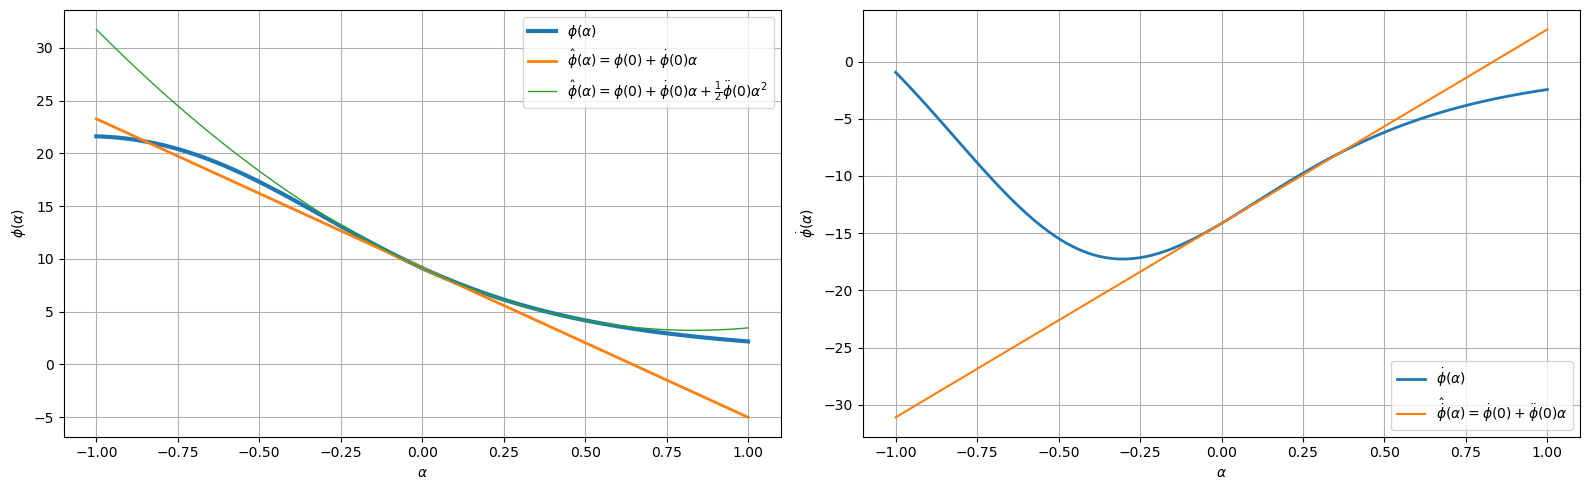

In [352]:
def test_function(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives_wrt_p(p + alpha * p_vec)
    return cost.T @ jacobian @ p_vec

def test_function_hessian(p, alpha, p_vec):
    n = len(p_vec)
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives_wrt_p(p + alpha * p_vec)
    hessian = second_order_partial_derivatives_wrt_p_pT(p + alpha * p_vec)
    return cost.T @ np.kron(np.eye(n), p_vec).T @ hessian @ p_vec + p_vec.T @ jacobian.T @ jacobian @ p_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
p = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to drag) wrt the velocity vector

In [353]:
def function(v_vec):
    p_vec = np.array([[1.0], [1.0], [1.0]])
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel

def first_order_partial_derivatives_wrt_v(v_vec):
    p_vec = np.array([[1.0], [1.0], [1.0]])
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm)

def second_order_partial_derivatives_wrt_v_vT(v_vec):
    p_vec = np.array([[1.0], [1.0], [1.0]])
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel)))

In [354]:
v1, v2, v3 = sp.symbols('v1 v2 v3')
p_vec = sp.Matrix([1.0, 1.0, 1.0])
p_norm = sp.sqrt(p_vec[0]**2 + p_vec[1]**2 + p_vec[2]**2)
v_vec = sp.Matrix([v1, v2, v3])
h = p_norm - R
rho = rho_0 * sp.exp(-(h - h_0) / H)
omega_vec = sp.Matrix([0, 0, 1.0])
v_vec_rel = v_vec - omega_vec.cross(p_vec)
v_rel_norm = sp.sqrt(v_vec_rel[0]**2 + v_vec_rel[1]**2 + v_vec_rel[2]**2)
fun = -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel
first_order_der = fun.jacobian(v_vec)
first_order_der_fun = sp.lambdify(v_vec, first_order_der.tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(v_vec[k]) for k in range(3)] for j in range(3)] for i in range(3)])
second_order_der_fun = sp.lambdify(v_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
sample_v_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_v_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives_wrt_v(sample_v_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_v_vec.flatten())).reshape((3 * 3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives_wrt_v_vT(sample_v_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_v_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives_wrt_v(sample_v_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_v_vec.flatten())).reshape((3 * 3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives_wrt_v_vT(sample_v_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


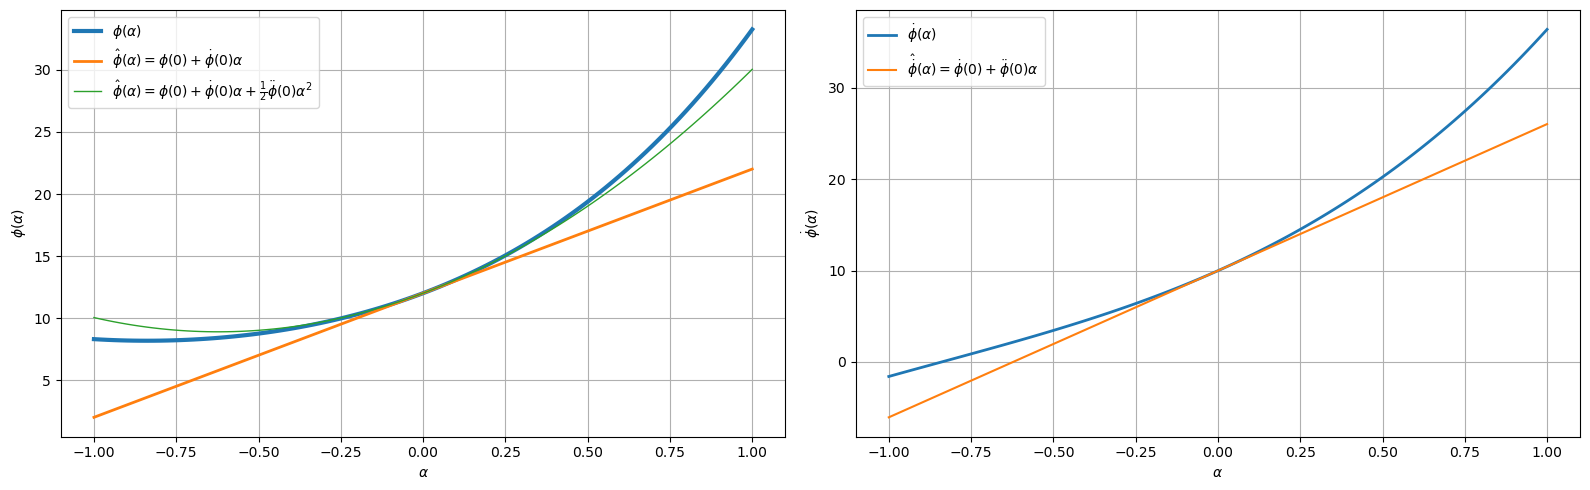

In [355]:
def test_function(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives_wrt_v(p + alpha * p_vec)
    return cost.T @ jacobian @ p_vec

def test_function_hessian(p, alpha, p_vec):
    n = len(p_vec)
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives_wrt_v(p + alpha * p_vec)
    hessian = second_order_partial_derivatives_wrt_v_vT(p + alpha * p_vec)
    return cost.T @ np.kron(np.eye(n), p_vec).T @ hessian @ p_vec + p_vec.T @ jacobian.T @ jacobian @ p_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
p = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to drag) wrt the position vector and then the velocity vector 

In [370]:
def function(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel

def first_order_partial_derivatives_wrt_p(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    return -1 / 2 * C_drag * A_drag / m * (rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec + v_rel_norm * v_vec_rel * drho_dp_vec.T)

def second_order_partial_derivatives_wrt_v_pT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term1 = rho * (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel))) @ dv_vec_rel_dp_vec
    term2 = np.kron((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm).reshape(-1, 1), drho_dp_vec.T)
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

### Derivatives for the differential equation (acceleration due to drag) wrt the velocity vector and then the position vector 

In [358]:
def function(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel

def first_order_partial_derivatives_wrt_v(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm)

def second_order_partial_derivatives_wrt_p_vT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega = 1.0
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term1 = rho * np.kron(np.eye(3), dv_vec_rel_dp_vec).T @ (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel)))
    term2 = np.kron(np.eye(3), drho_dp_vec) @ (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm)
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

### Derivatives for the differential equation (acceleration due to drag) wrt the state vector for one agent

In [360]:
def function(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel

def first_order_partial_derivatives_wrt_p(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    return -1 / 2 * C_drag * A_drag / m * (rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec + v_rel_norm * v_vec_rel * drho_dp_vec.T)

def first_order_partial_derivatives_wrt_v(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm)

def second_order_partial_derivatives_wrt_p_pT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    d2rho_dp_vec2 = rho_0 / H**2 * np.exp(-(h - h_0) / H) * p_vec * p_vec.T / p_norm**2 - rho_0 / H * np.exp(-(h - h_0) / H) * (np.eye(3) / p_norm - p_vec * p_vec.T / p_norm**3)
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term11 = rho * np.kron(np.eye(3), dv_vec_rel_dp_vec).T @ (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel))) @ dv_vec_rel_dp_vec
    term12 = np.kron(np.eye(3), drho_dp_vec) @ ((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec)
    term1 = term11 + term12
    term21 = np.kron(((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm) @ dv_vec_rel_dp_vec).reshape(-1, 1), drho_dp_vec.T)
    term22 = np.kron(v_rel_norm * v_vec_rel, np.eye(3)) @ d2rho_dp_vec2
    term2 = term21 + term22
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

def second_order_partial_derivatives_wrt_v_pT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term1 = rho * (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel))) @ dv_vec_rel_dp_vec
    term2 = np.kron((v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm).reshape(-1, 1), drho_dp_vec.T)
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

def second_order_partial_derivatives_wrt_p_vT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    drho_dp_vec = -rho_0 / H * np.exp(-(h - h_0) / H) * p_vec / p_norm
    dv_vec_rel_dp_vec = np.array([[0, omega, 0], [-omega, 0, 0], [0, 0, 0]])
    term1 = rho * np.kron(np.eye(3), dv_vec_rel_dp_vec).T @ (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel)))
    term2 = np.kron(np.eye(3), drho_dp_vec) @ (v_rel_norm * np.eye(3) + v_vec_rel * v_vec_rel.T / v_rel_norm)
    return -1 / 2 * C_drag * A_drag / m * (term1 + term2)

def second_order_partial_derivatives_wrt_v_vT(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    p_norm = np.linalg.norm(p_vec)
    h = p_norm - R
    rho = rho_0 * np.exp(-(h - h_0) / H)
    omega_vec = np.array([[0], [0], [omega]]) 
    v_vec_rel = v_vec - np.cross(omega_vec.reshape(3,), p_vec.reshape(3,)).reshape(3, 1)
    v_rel_norm = np.linalg.norm(v_vec_rel)
    return -1 / 2 * C_drag * A_drag / m * rho * (1 / v_rel_norm * (np.kron(np.eye(3), v_vec_rel) + np.kron(np.eye(3).reshape(-1, 1), v_vec_rel.T) + np.kron(v_vec_rel, np.eye(3))) - 1 / v_rel_norm**3 * np.kron(v_vec_rel, np.outer(v_vec_rel, v_vec_rel)))

In [366]:
def differential_equation(x_vec):
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(x_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_pder = np.zeros((6, 6))
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = first_order_partial_derivatives_wrt_p(x_vec).reshape((3, 3))
    first_order_pder[3:, 3:] = first_order_partial_derivatives_wrt_v(x_vec).reshape((3, 3))
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_pder = np.zeros((n, n, n))
    aux_pp = second_order_partial_derivatives_wrt_p_pT(x_vec).reshape((3, 3, 3))
    aux_pv = second_order_partial_derivatives_wrt_p_vT(x_vec).reshape((3, 3, 3))
    aux_vp = second_order_partial_derivatives_wrt_v_pT(x_vec).reshape((3, 3, 3))
    aux_vv = second_order_partial_derivatives_wrt_v_vT(x_vec).reshape((3, 3, 3))
    for i in range(3):
        second_order_pder[3:, :3, i] += aux_pp[:, :, i]
        second_order_pder[3:, :3, i + 3] += aux_pv[:, :, i]
        second_order_pder[3:, 3:, i] += aux_vp[:, :, i]
        second_order_pder[3:, 3:, i + 3] += aux_vv[:, :, i]
    return second_order_pder

In [367]:
# Symbolic
p1, p2, p3, v1, v2, v3 = sp.symbols('p1 p2 p3 v1 v2 v3')
p_vec = sp.Matrix([p1, p2, p3])
v_vec = sp.Matrix([v1, v2, v3])
x_vec = sp.Matrix([p1, p2, p3, v1, v2, v3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
h = p_norm - R
rho = rho_0 * sp.exp(-(h - h_0) / H)
omega_vec = sp.Matrix([0, 0, omega])
v_vec_rel = v_vec - omega_vec.cross(p_vec)
v_rel_norm = sp.sqrt(v_vec_rel[0]**2 + v_vec_rel[1]**2 + v_vec_rel[2]**2)
fun = sp.Matrix.vstack(v_vec, -1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel)
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, first_order_der.tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(x_vec[k]) for k in range(6)] for j in range(6)] for i in range(6)])
second_order_der_fun = sp.lambdify(x_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
# sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6))
first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape(6 * 6, 6)
second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec).reshape(6 * 6, 6)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((6 * 6, 6))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec).reshape((6 * 6, 6))
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


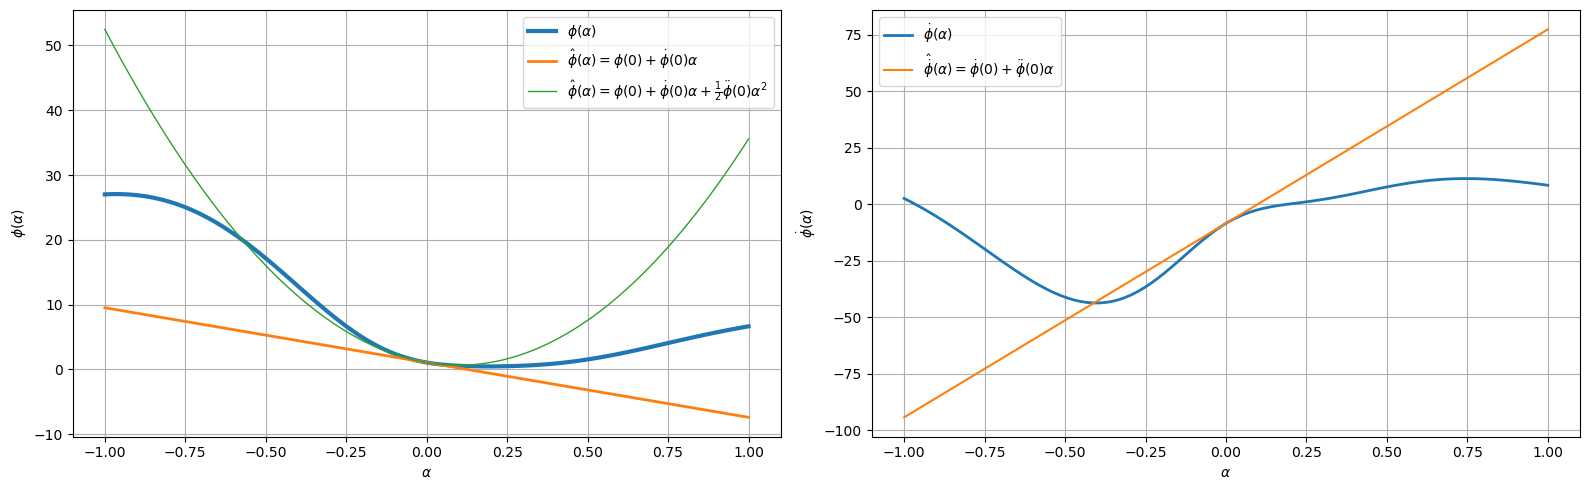

In [368]:
def test_function(p, alpha, x_vec):
    cost = differential_equation(p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, x_vec):
    cost = differential_equation(p + alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(p, alpha, x_vec):
    n = len(x_vec)
    cost = differential_equation(p + alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    hessian = second_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec).reshape((n * n, n))
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
p = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()